# 应用卷积神经网络

应用卷积神经网络实现情感分类

请你多多使用工程思维、标准化格式完成作业：

能够读取格式固定的训练、测试数据

格式输出 Accuracy and Confusion Matrix 结果

# 卷积神经网络用语自然语言处理示例

In [1]:
# 示例代码运行环境
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

CPython 3.6.2
IPython 6.1.0

tensorflow 1.3.0
numpy 1.13.3

compiler   : GCC 4.2.1 (Apple Inc. build 5666) (dot 3)
system     : Darwin
release    : 17.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import jieba
from collections import Counter
import time
%matplotlib inline

## 数据清洗（此部分参照 ch5-task01）

In [3]:
# 读取文件，将内容及标签分别存放
def read_doc(file):
    docs = []
    labels = []
    with open(file) as f:
        for line in f.readlines():
            labels.append(line.strip().split("\t")[1]) # 取出标签
            words = []
            for word in jieba.cut(line.strip()):
                if word>=u'\u4e00' and word<=u'\u9fff': # 去掉标点、英文等字符
                    words.append(word)
            docs.append(words)
    return docs,labels

In [4]:
filelist = ["../code/train_shuffle.txt", "../code/test_shuffle.txt"]

In [5]:
# train_shuffle.txt 的第 14058 行，评论为空，label 为0，
# 这样会导致 IndexError: list index out of range,删除后 OK

train_docs,train_labels = read_doc(filelist[0])
test_docs,test_labels = read_doc(filelist[1])

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/g5/df85rhb10jb9qpw1wdlh0t_m0000gn/T/jieba.cache
Loading model cost 1.031 seconds.
Prefix dict has been built succesfully.


In [6]:
# 固定句子长度和 padding
fix_length = 30
padding = ['<PD>']

In [7]:
# 将所有样本设定为固定长度，小于 fix_length 用 Padding 填充
# 大于 fix_length 的部分，从后面截断
def get_padding(docs):
    for i in range(len(docs)):
        if len(docs[i]) < fix_length:
            docs[i].extend(padding*(fix_length-len(docs[i])))
        else:
            docs[i] = docs[i][:fix_length]
    return docs

In [8]:
train_content = get_padding(train_docs)
test_content = get_padding(test_docs)

In [9]:
# 统计词频
def get_counter(docs):
    all_words = []
    for words in docs:
        for word in words:
            all_words.append(word)
    word_cnt = Counter(all_words)
    return word_cnt

In [10]:
train_cnt = get_counter(train_content)

In [11]:
# 建立词表
def built_vocab(word_cnt):
    vocab = ['UNK']
    for i in train_cnt.most_common():
        if i[1] > 3:
            vocab.append(i[0])
        else:
            break
    return vocab

In [12]:
vocab = built_vocab(train_cnt)
vocab_size = len(vocab)

In [13]:
# 由词映射到序号的字典，可以用分词来查询，得到一个数字
idx_dict = dict(zip(vocab, range(len(vocab))))

In [14]:
# 将词列表转化成序号列表
def index_list(docs):
    indexs = []
    for contents in docs:
        index_content = []
        for word in contents:
            idx = idx_dict[word] if (word in vocab) else 0
            index_content.append(idx)
        indexs.append(index_content)
    return indexs

In [15]:
# 获取训练数据
x_train = np.asarray(index_list(train_content)).astype('int32')
y_train = np.asarray(train_labels).astype('int32')

In [16]:
# 获取测试数据
x_test = np.asarray(index_list(test_content)).astype('int32')
y_test = np.asarray(test_labels).astype('int32')

In [17]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, vocab_size)

(24585, 30) (24585,) (10538, 30) (10538,) 9043


## 卷积神经网络

In [18]:
# 定义神经网络
# 输入词序号 -> 词向量 -> 卷积层（tanh） -> max_pool 层 -> 全连接层（sigmoid） -> 输出层
word_embed_size = 128
filter_num = 64
window_size = 3

In [32]:
tf.reset_default_graph()

In [19]:
# 随机生成词向量，词向量大小为 word_embed_size
tf.reset_default_graph()
W = tf.Variable(tf.random_uniform([vocab_size, word_embed_size], -1.0, 1.0),
                name='W')
x_ = tf.placeholder(tf.int32, shape=[None, fix_length], name='x_')
y_ = tf.placeholder(tf.int32, shape=[None], name='y_')

In [20]:
# 用 x_ 查找 W （词向量）
embeds = tf.nn.embedding_lookup(W, x_)

In [21]:
# 为了适应 conv2d 的参数，拓展了一个维度（in_channel），数量为 1
embeds_expand = tf.expand_dims(embeds, -1)

In [22]:
embeds_expand

<tf.Tensor 'ExpandDims:0' shape=(?, 30, 128, 1) dtype=float32>

In [23]:
# 构建 conv 层和 max_pooling 层
with tf.name_scope("conv-maxpool"):
    # 定义卷积核，一次对多少元素进行卷积
    # 此处，filter_shape 的第一维对应于 embeds_expand 的第二维，即一次处理多少分词数
    # 第二维对应于 embeds_expand 的第三维，一次处理词向量的多少维度。
    # 第三维对应于 embeds_expand 的第四维，维通道数。
    # 第四维维输出结果的维度
    # 因此，卷积核将 3 个 128 维的词向量编程 1 个 64 维词向量
    filter_shape = [window_size, word_embed_size, 1, filter_num]
    # 定义卷积参数 W, b
    W = tf.Variable(tf.random_uniform(filter_shape, -1.0, 1.0), name="W")
    b = tf.Variable(tf.constant(0.0, shape=[filter_num]), name='b')
    # strides 四个维度都为 1，即每次计算在每个维度上滑动一个元素
    # “VALID”模型不做 Padding
    conv = tf.nn.conv2d(
        embeds_expand, W, strides=[1, 1, 1, 1],
        padding="VALID", name="conv")
    
    # 卷积出来结果加上 bias
    conv_hidden = tf.nn.tanh(tf.add(conv, b), name="tanh")
    
    # 因为没有 padding，出来的结果个数是 sequence_length - window_size + 1
    # 如果加了 padding 这里要对应更改
    pool = tf.nn.max_pool(
        conv_hidden,
        ksize=[1, fix_length - window_size + 1, 1, 1],
        strides=[1, 1, 1, 1],
        padding='VALID',
        name="pool")
    
embeds_expand, filter_shape, conv, conv_hidden, pool

(<tf.Tensor 'ExpandDims:0' shape=(?, 30, 128, 1) dtype=float32>,
 [3, 128, 1, 64],
 <tf.Tensor 'conv-maxpool/conv:0' shape=(?, 28, 1, 64) dtype=float32>,
 <tf.Tensor 'conv-maxpool/tanh:0' shape=(?, 28, 1, 64) dtype=float32>,
 <tf.Tensor 'conv-maxpool/pool:0' shape=(?, 1, 1, 64) dtype=float32>)

In [24]:
# squeeze 作用是去除维度，作用与 expand_dims 相反
squeezed_pool = tf.squeeze(pool, [1, 2])

In [25]:
squeezed_pool

<tf.Tensor 'Squeeze:0' shape=(?, 64) dtype=float32>

In [26]:
raw_output = tf.layers.dense(squeezed_pool, 2)
output = tf.nn.softmax(raw_output)

In [27]:
# 定义损失函数
cost = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=raw_output, labels=y_)
)

In [28]:
# 评估模型指标, 并打印输出
def evaluate_model(sess, inputs_, labels_, print_matrix=True):
    pred_prob = sess.run(output, feed_dict={x_:inputs_, y_:labels_})
    preds = np.asarray((pred_prob[:, 1] > 0.5), dtype=int)
    mat = sess.run(tf.confusion_matrix(labels_, preds))
    tn, fp, fn, tp = mat.reshape(4)
    Accuracy = (tp + tn) / (tn + fp + fn + tp)
    if print_matrix:
        print(' confusion matrix:\n', mat)
    print('Accuracy  {:.3f}'.format(Accuracy))

In [29]:
# 定义模型相关参数
batch_size = 100
epochs = 2000
print_cost_every = 10

feed_train = {x_: x_train, y_: y_train}
feed_test = {x_: x_test, y_: y_test}

sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_step = tf.train.GradientDescentOptimizer(0.3).minimize(cost)

costs_train = []
costs_test = []
start_time = time.time()

num_inputs = len(x_train)
order = np.arange(num_inputs)
np.random.shuffle(order)

In [30]:
# 训练模型，并打印评估结果
try:
    for i in range(epochs):
        if i % print_cost_every == 0:
            cost_train =sess.run(cost, feed_dict=feed_train)
            cost_test = sess.run(cost, feed_dict=feed_test)
            costs_train.append(cost_train)
            costs_test.append(cost_test)
            print('epoch {:03d} cost: train {:.3f} / test {:.3f}'.format(
                i, cost_train, cost_test))
            evaluate_model(sess, x_test, y_test)
            
        for j in range(0, num_inputs, batch_size):
            batch_index = order[j: j + batch_size]
            batch_inputs = x_train[batch_index]
            batch_labels = y_train[batch_index]
            batch_feed = {x_: batch_inputs, y_: batch_labels}
            sess.run(train_step, feed_dict=batch_feed)
except KeyboardInterrupt:
    print('Interrupted')
finally:
    end_time = time.time()
    print('\ntime: {:.2f} s'.format(end_time - start_time))

epoch 000 cost: train 1.214 / test 1.211
 confusion matrix:
 [[5569    4]
 [4963    2]]
Accuracy  0.529
epoch 010 cost: train 3.489 / test 3.705
 confusion matrix:
 [[5447  126]
 [4307  658]]
Accuracy  0.579
epoch 020 cost: train 0.786 / test 1.309
 confusion matrix:
 [[2289 3284]
 [ 240 4725]]
Accuracy  0.666
epoch 030 cost: train 0.382 / test 0.956
 confusion matrix:
 [[3123 2450]
 [ 311 4654]]
Accuracy  0.738
epoch 040 cost: train 0.307 / test 0.911
 confusion matrix:
 [[3469 2104]
 [ 343 4622]]
Accuracy  0.768
epoch 050 cost: train 0.279 / test 0.934
 confusion matrix:
 [[3651 1922]
 [ 375 4590]]
Accuracy  0.782
epoch 060 cost: train 0.198 / test 0.875
 confusion matrix:
 [[3860 1713]
 [ 386 4579]]
Accuracy  0.801
Interrupted

time: 417.36 s


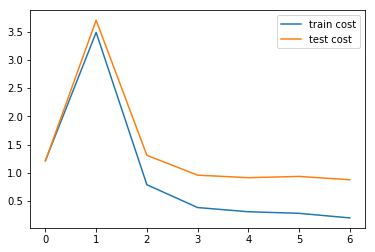

In [31]:
plt.plot(costs_train, label='train cost')
plt.plot(costs_test, label='test cost')
plt.legend();